# House price regression

The main goal of this project is to estimate the sale price of real estate

## Problem
We got hired by a real estate investor in order to propose him a software solution to estimate quickly the value of housholds. The goal of this application is to scan the whole real estate market in order to indentify undervaluate household.

## Solution
To answer this problem, we propose a regression algorithm that will estimate the value of household given some specific properties. Then by comparing the estimate value against the market value, we'll be able to spot investment opportunities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


Bad key "text.dvipnghack" on line 127 in
/home/benoit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "nbagg.transparent" on line 433 in
/home/benoit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_path" on line 516 in
/home/benoit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_a

### Data import, cleaning and analysis
The first step would be to import the data in order to prepare it for the algorithm.
To do so, we'll start by importing the data and list every feature

In [2]:
data = pd.read_csv('train.csv')
for name,dtype in zip(data.columns, data.dtypes):
    print(name,": ", dtype, "         Ex: ", data[name].iloc[0], "    Number of NaN: ", data[name].isnull().sum())

Id :  int64          Ex:  1     Number of NaN:  0
MSSubClass :  int64          Ex:  60     Number of NaN:  0
MSZoning :  object          Ex:  RL     Number of NaN:  0
LotFrontage :  float64          Ex:  65.0     Number of NaN:  259
LotArea :  int64          Ex:  8450     Number of NaN:  0
Street :  object          Ex:  Pave     Number of NaN:  0
Alley :  object          Ex:  nan     Number of NaN:  1369
LotShape :  object          Ex:  Reg     Number of NaN:  0
LandContour :  object          Ex:  Lvl     Number of NaN:  0
Utilities :  object          Ex:  AllPub     Number of NaN:  0
LotConfig :  object          Ex:  Inside     Number of NaN:  0
LandSlope :  object          Ex:  Gtl     Number of NaN:  0
Neighborhood :  object          Ex:  CollgCr     Number of NaN:  0
Condition1 :  object          Ex:  Norm     Number of NaN:  0
Condition2 :  object          Ex:  Norm     Number of NaN:  0
BldgType :  object          Ex:  1Fam     Number of NaN:  0
HouseStyle :  object          Ex: 

Given this analysis, we can notice that some features doesn't contain any valuable information
Those features are:
- Id
- ...

In addition of that, we notice that there is many missing values. The job here would be to differanciate missing values (errors in the dataset) from the absence of the concernate feature in the house.

In the first case, we'll remove the row.

In the second case, we'll considere any object that can be absent as added value, and thus replacing NaNs by zero.

In [3]:
data.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [4]:
for column in data:
    print(data[column].value_counts())

1460    1
479     1
481     1
482     1
483     1
       ..
976     1
977     1
978     1
979     1
1       1
Name: Id, Length: 1460, dtype: int64
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 110, dtype: int64
7200     25
9600     24
6000     17
10800    14
9000     14
         ..
7094      1
6130      1
9337      1
5232      1
8190      1
Name: LotArea, Length: 1073, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311


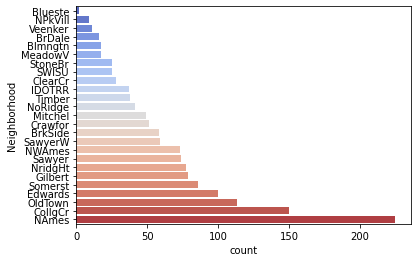

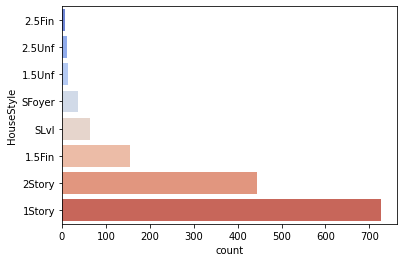

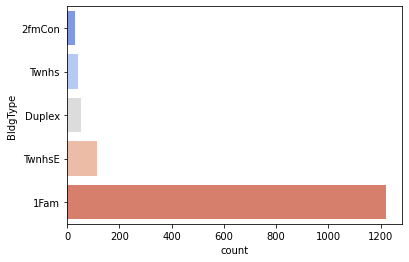

In [5]:
ax = sns.countplot(y="Neighborhood", data=data, order=data["Neighborhood"].value_counts().sort_values().index, palette ='coolwarm') #comment changer la taille
plt.show()
ax = sns.countplot(y="HouseStyle", data=data, order=data["HouseStyle"].value_counts().sort_values().index, palette ='coolwarm') #comment changer la taille
plt.show()
ax = sns.countplot(y="BldgType", data=data, order=data["BldgType"].value_counts().sort_values().index, palette ='coolwarm') #comment changer la taille
plt.show()


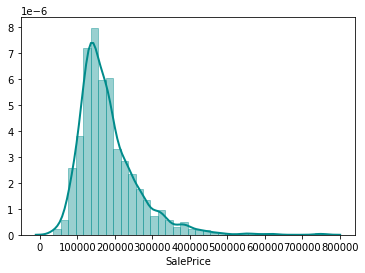

In [6]:
# Price distribution

sns.distplot(data["SalePrice"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkcyan', 
             hist_kws={'edgecolor':'darkcyan'},
             kde_kws={'linewidth': 2})

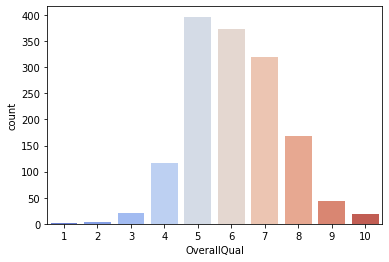

In [7]:
# Overall quality

ax = sns.countplot(x="OverallQual", data=data, palette ='coolwarm') 
plt.show()

Clean Nan
Given this analysis, we can notice that some features do not contain any valuable information. The ID Column is a good example. For this reason the ID column will be droped from the test set

In addition of that, we notice that there is many missing values. The job here would be to differanciate missing values (errors in the dataset) from the absence of the concernate feature in the house.

In the first case some columns have a high amount of missing values and might be related to other column that are more complete. The columns with a significant amount of missing values are:

- LotFrontage: 259 NaN
- Alley: 1369 NaN
- FireplaceQu: 690 NaN
- PoolQC: 1453 NaN
- Fence: 1179 NaN
- MiscFeature: 1406 NaN

For LotFrontage, since there is difficult to have no frontage we assumed that the NaN values can be replaced by the median. For PoolQC and MiscFeature that have above 95% of missing values and taken into account that the features PoolArea and MiscVal were complete, it was possible to remowe the features. In the case of the others the NaN values were set to 0 since it is probable that they the houses do not have this feature.

For the same reason, all the lower missing value number were also set to 0.

In [8]:
#Trop de Nan et était déjà quasiment expliqué par une autre colonne
data_cleaned=data.drop(columns=["Id","PoolQC","MiscFeature"] )  

data_cleaned['LotFrontage'] = data_cleaned['LotFrontage'].fillna(data_cleaned['LotFrontage'].median()) #remplacer les Nan par la médiane
data_cleaned['Alley'] = data_cleaned['Alley'].fillna(0) #y'a pas d'alley donc 0
data_cleaned['MasVnrType'] = data_cleaned['MasVnrType'].fillna('None') #Car la plupart des valeur c'est None
data_cleaned['MasVnrArea'] = data_cleaned['MasVnrArea'].fillna(0) #quand y'en a pas


#la y'a juste pas de basement
data_cleaned['BsmtQual'] = data_cleaned['BsmtQual'].fillna(0)
data_cleaned['BsmtCond'] = data_cleaned['BsmtCond'].fillna(0)
data_cleaned['BsmtExposure'] = data_cleaned['BsmtExposure'].fillna(0)
data_cleaned['BsmtFinType1'] = data_cleaned['BsmtFinType1'].fillna(0)
data_cleaned['BsmtFinType2'] = data_cleaned['BsmtFinType2'].fillna(0)
data_cleaned['BsmtCond'] = data_cleaned['BsmtCond'].fillna(0)


data_cleaned['Electrical'] = data_cleaned['Electrical'].fillna(0) #disont que cette maison n'a pas d'électricité

data_cleaned['FireplaceQu'] = data_cleaned['FireplaceQu'].fillna(0) #et pas de Fireplace

data_cleaned['GarageType'] = data_cleaned['GarageType'].fillna(0) # ni garage
data_cleaned['GarageYrBlt'] = data_cleaned['GarageYrBlt'].fillna(0) 
data_cleaned['GarageFinish'] = data_cleaned['GarageFinish'].fillna(0) 
data_cleaned['GarageQual'] = data_cleaned['GarageQual'].fillna(0) 
data_cleaned['GarageCond'] = data_cleaned['GarageCond'].fillna(0) 

data_cleaned['Fence'] = data_cleaned['Fence'].fillna(0) #pas de cloture

for name,dtype in zip(data_cleaned.columns, data_cleaned.dtypes):
    print(name,": ", dtype, "         Ex: ", data_cleaned[name].iloc[0], "    Number of NaN: ", data_cleaned[name].isnull().sum())

MSSubClass :  int64          Ex:  60     Number of NaN:  0
MSZoning :  object          Ex:  RL     Number of NaN:  0
LotFrontage :  float64          Ex:  65.0     Number of NaN:  0
LotArea :  int64          Ex:  8450     Number of NaN:  0
Street :  object          Ex:  Pave     Number of NaN:  0
Alley :  object          Ex:  0     Number of NaN:  0
LotShape :  object          Ex:  Reg     Number of NaN:  0
LandContour :  object          Ex:  Lvl     Number of NaN:  0
Utilities :  object          Ex:  AllPub     Number of NaN:  0
LotConfig :  object          Ex:  Inside     Number of NaN:  0
LandSlope :  object          Ex:  Gtl     Number of NaN:  0
Neighborhood :  object          Ex:  CollgCr     Number of NaN:  0
Condition1 :  object          Ex:  Norm     Number of NaN:  0
Condition2 :  object          Ex:  Norm     Number of NaN:  0
BldgType :  object          Ex:  1Fam     Number of NaN:  0
HouseStyle :  object          Ex:  2Story     Number of NaN:  0
OverallQual :  int64       

In [9]:
data_cleaned['MSZoning'] = data_cleaned['MSZoning'].replace("C (all)", 0).replace("RH", 1).replace("RM", 2).replace("RL", 3).replace("FV", 4)
data_cleaned['Street'] = data_cleaned['Street'].replace("Grvl", 1).replace("Pave", 2)
data_cleaned['Alley'] = data_cleaned['Alley'].replace("Grvl", 1).replace("Pave", 2)
data_cleaned['LotShape'] = data_cleaned['LotShape'].replace("Reg", 0).replace("IR1", 1).replace("IR2", 2).replace("IR3", 3) #retrouver le petit quartier pour adapter les codes
data_cleaned['LandContour'] = data_cleaned['LandContour'].replace("Low", 0).replace("HLS", 1).replace("Bnk", 2).replace("Lvl", 3) #A voir si les valeur ont du sens
data_cleaned['Utilities'] = data_cleaned['Utilities'].replace("NoSeWa", 0).replace("AllPub", 1)
data_cleaned['LotConfig'] = data_cleaned['LotConfig'].replace("Inside", 0).replace("Corner", 1).replace("FR2", 2).replace("FR3", 3).replace("CulDSac", 4)
data_cleaned['LandSlope'] = data_cleaned['LandSlope'].replace("Sev", 0).replace("Mod", 1).replace("Gtl", 2)
data_cleaned['Neighborhood'] = data_cleaned['Neighborhood'].replace("NAmes", 0).replace("CollgCr",1).replace("OldTown",2).replace("Edwards",3).replace("Somerst", 4).replace("Gilbert", 5).replace("NridgHt", 6).replace("Sawyer", 7).replace("NWAmes",8).replace("SawyerW", 9).replace("BrkSide",10).replace("Crawfor",11).replace("Mitchel",12).replace("NoRidge", 13).replace("Timber", 14).replace("IDOTRR", 15).replace("ClearCr",16).replace("SWISU", 17).replace("StoneBr", 18).replace("Blmngtn", 19).replace("MeadowV", 20).replace("BrDale", 21).replace("Veenker", 22).replace("NPkVill", 23).replace("Blueste", 24)

data_cleaned['Condition1'] = data_cleaned['Condition1'].replace("Norm", 0).replace("Feedr", 1).replace("Artery", 2).replace("RRAn", 3).replace("PosN", 4).replace("RRAe", 5).replace("PosA", 6).replace("RRNn", 7).replace("RRNe", 8)
data_cleaned['Condition2'] = data_cleaned['Condition2'].replace("Norm", 0).replace("Feedr", 1).replace("Artery", 2).replace("RRAn", 3).replace("PosN", 4).replace("RRAe", 5).replace("PosA", 6).replace("RRNn", 7).replace("RRNe", 8)

data_cleaned['BldgType'] = data_cleaned['BldgType'].replace("1Fam", 0).replace("TwnhsE", 1).replace("Duplex", 2).replace("Twnhs", 3).replace("2fmCon", 4)
data_cleaned['HouseStyle'] = data_cleaned['HouseStyle'].replace("1Story", 0).replace("2Story", 1).replace("1.5Fin", 2).replace("SLvl", 3).replace("SFoyer", 4).replace("1.5Unf", 5).replace("2.5Unf", 6).replace("2.5Fin", 7)

data_cleaned['RoofStyle'] = data_cleaned['RoofStyle'].replace("Gable", 0).replace("Hip", 1).replace("Flat", 2).replace("Gambrel", 3).replace("Mansard", 4).replace("Shed", 5)
data_cleaned['RoofMatl'] = data_cleaned['RoofMatl'].replace("CompShg", 0).replace("Tar&Grv", 1).replace("MetalSd", 2).replace("WdShngl", 3).replace("WdShake", 4).replace("ClyTile",6).replace("Membran", 6).replace("Roll", 7).replace("Metal", 8)

data_cleaned['Exterior1st'] = data_cleaned['Exterior1st'].replace("VinylSd", 0).replace("HdBoard", 1).replace("MetalSd", 2).replace("Wd Sdng", 3).replace("Plywood", 4).replace("CemntBd",5).replace("BrkFace", 6).replace("WdShing", 7).replace("Stucco", 8).replace("AsbShng", 9).replace("Stone",10).replace("BrkComm", 11).replace("CBlock", 12).replace("ImStucc", 13).replace("AsphShn", 14)
data_cleaned['Exterior2nd'] = data_cleaned['Exterior2nd'].replace("VinylSd", 0).replace("HdBoard", 1).replace("MetalSd", 2).replace("Wd Sdng", 3).replace("Plywood", 4).replace("CemntBd",5).replace("BrkFace", 6).replace("Wd Shng", 7).replace("Stucco", 8).replace("AsbShng", 9).replace("Stone",10).replace("BrkComm", 11).replace("CBlock", 12).replace("ImStucc", 13).replace("AsphShn", 14).replace("CmentBd", 15).replace("Wd Shbg", 16).replace("Brk Cmn", 17).replace("Other", 18)

data_cleaned['MasVnrType'] = data_cleaned["MasVnrType"].replace("None", 0).replace("BrkFace", 1).replace("Stone", 2).replace("BrkCmn", 3) #Classer

data_cleaned['ExterQual'] = data_cleaned['ExterQual'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['ExterCond'] = data_cleaned['ExterQual'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)

data_cleaned['Foundation'] = data_cleaned['Foundation'].replace("PConc", 0).replace("CBlock", 1).replace("BrkTil", 2).replace("Slab", 3).replace("Stone", 4).replace("Wood",5) #A adapter Ordre décroissant
data_cleaned['BsmtQual'] = data_cleaned['BsmtQual'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5) #Droper NA et classer dans l'ordre 
data_cleaned['BsmtCond'] = data_cleaned['BsmtCond'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5) # la même jusqu'à Total jusqu'au heat
data_cleaned['BsmtExposure'] = data_cleaned['BsmtExposure'].replace("No", 1).replace("Mn", 2).replace("Av", 3).replace("Gd", 4)
data_cleaned['BsmtFinType1'] = data_cleaned['BsmtFinType1'].replace("Unf", 1).replace("LwQ", 2).replace("Rec", 3).replace("BLQ", 4).replace("ALQ", 5).replace("GLQ", 6)
data_cleaned['BsmtFinType2'] = data_cleaned['BsmtFinType2'].replace("Unf", 1).replace("LwQ", 2).replace("Rec", 3).replace("BLQ", 4).replace("ALQ", 5).replace("GLQ", 6)

data_cleaned['Heating'] = data_cleaned['Heating'].replace("Wall", 1).replace("OthW", 2).replace("Grav", 3).replace("GasW", 4).replace("GasA", 5).replace("Floor", 6) #Chaufage au sol meilleur et 0 si pas de chauffage
data_cleaned['HeatingQC'] = data_cleaned['HeatingQC'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['CentralAir'] = data_cleaned['CentralAir'].replace("Y", 1).replace("N", 0)
data_cleaned['Electrical'] = data_cleaned['Electrical'].replace("SBrkr", 1).replace("FuseA", 2).replace("FuseF", 3).replace("FuseP", 4).replace("Mix", 5) 
data_cleaned['KitchenQual'] = data_cleaned['KitchenQual'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5) 
data_cleaned['Functional'] = data_cleaned['Functional'].replace("Typ", 0).replace("Min2", 1).replace("Min1", 2).replace("Mod", 3).replace("Maj1", 4).replace("Maj2", 5).replace("Sev",6)
data_cleaned['FireplaceQu'] = data_cleaned['FireplaceQu'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['GarageType'] = data_cleaned['GarageType'].replace("Attchd", 1).replace("Detchd", 2).replace("BuiltIn", 3).replace("Basment", 4).replace("CarPort", 5).replace("2Types", 6) 
data_cleaned['GarageFinish'] = data_cleaned['GarageFinish'].replace("Unf", 1).replace("RFn", 2).replace("Fin", 3)
data_cleaned['GarageQual'] = data_cleaned['GarageQual'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['GarageCond'] = data_cleaned['GarageCond'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['PavedDrive'] = data_cleaned['PavedDrive'].replace("N", 0).replace("P", 1).replace("Y", 2) 
#data_cleaned['PoolQC'] = data_cleaned['PoolQC'].replace("Po", 1).replace("Fa", 2).replace("TA", 3).replace("Gd", 4).replace("Ex", 5)
data_cleaned['Fence'] = data_cleaned['Fence'].replace("MnWw", 1).replace("GdWo", 2).replace("MnPrv", 3).replace("GdPrv", 4) 
#data_cleaned['MiscFeature'] = data_cleaned['MiscFeature'].replace("Othr", 1).replace("Shed", 2).replace("Gar2", 3).replace("TenC", 4).replace("Elev", 5)
data_cleaned['SaleType'] = data_cleaned['SaleType'].replace("WD", 0).replace("New", 1).replace("COD", 2).replace("ConLD", 3).replace("ConLw", 4).replace("ConLI", 5).replace("CWD", 6).replace("Oth", 7).replace("Con",8)
data_cleaned['SaleCondition'] = data_cleaned['SaleCondition'].replace("Normal", 0).replace("Partial",1).replace("Abnorml", 2).replace("Family", 3).replace("Alloca", 4).replace("AdjLand", 5)

In [10]:

for name,dtype in zip(data_cleaned.columns, data_cleaned.dtypes):
    print(name,": ", dtype, "         Ex: ", data_cleaned[name].iloc[0], "    Number of NaN: ", data_cleaned[name].isnull().sum())

for column in data_cleaned:
    print("---------------\n", data_cleaned[column].value_counts())

MSSubClass :  int64          Ex:  60     Number of NaN:  0
MSZoning :  int64          Ex:  3     Number of NaN:  0
LotFrontage :  float64          Ex:  65.0     Number of NaN:  0
LotArea :  int64          Ex:  8450     Number of NaN:  0
Street :  int64          Ex:  2     Number of NaN:  0
Alley :  int64          Ex:  0     Number of NaN:  0
LotShape :  int64          Ex:  0     Number of NaN:  0
LandContour :  int64          Ex:  3     Number of NaN:  0
Utilities :  int64          Ex:  1     Number of NaN:  0
LotConfig :  int64          Ex:  0     Number of NaN:  0
LandSlope :  int64          Ex:  2     Number of NaN:  0
Neighborhood :  int64          Ex:  1     Number of NaN:  0
Condition1 :  int64          Ex:  0     Number of NaN:  0
Condition2 :  int64          Ex:  0     Number of NaN:  0
BldgType :  int64          Ex:  0     Number of NaN:  0
HouseStyle :  int64          Ex:  1     Number of NaN:  0
OverallQual :  int64          Ex:  7     Number of NaN:  0
OverallCond :  int64 

Given this analysis, we can notice that some features doesn't contain any valuable information Those features are:

Id
...
In addition of that, we notice that there is many missing values. The job here would be to differanciate missing values (errors in the dataset) from the absence of the concernate feature in the house.

In the first case, we'll remove the row.

In the second case, we'll considere any object that can be absent as added value, and thus replacing NaNs by zero.

In [11]:
data_cleaned.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,2.852740,69.863699,10516.828082,1.995890,0.090411,0.408219,2.814384,0.999315,0.510274,...,3.409589,15.060959,2.758904,0.565753,43.489041,6.321918,2007.815753,0.233562,0.311644,180921.195890
std,42.300571,0.527086,22.027677,9981.264932,0.063996,0.372151,0.582296,0.606509,0.026171,1.050750,...,29.317331,55.757415,40.177307,1.204483,496.123024,2.703626,1.328095,0.793805,0.767397,79442.502883
min,20.000000,0.000000,21.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000,34900.000000
25%,20.000000,3.000000,60.000000,7553.500000,2.000000,0.000000,0.000000,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,0.000000,0.000000,129975.000000
50%,50.000000,3.000000,69.000000,9478.500000,2.000000,0.000000,0.000000,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,0.000000,0.000000,163000.000000
75%,70.000000,3.000000,79.000000,11601.500000,2.000000,0.000000,1.000000,3.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,0.000000,0.000000,214000.000000
max,190.000000,4.000000,313.000000,215245.000000,2.000000,2.000000,3.000000,3.000000,1.000000,4.000000,...,508.000000,480.000000,738.000000,4.000000,15500.000000,12.000000,2010.000000,8.000000,5.000000,755000.000000


In [12]:
print(data.shape)
print(data_cleaned.shape)

(1460, 81)
(1460, 78)


In [13]:
corr = data_cleaned.corr()
corrVal=corr["SalePrice"].sort_values(ascending=False).to_frame()
corrVal.head(50)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
ExterCond,0.682639
ExterQual,0.682639
KitchenQual,0.659600
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852


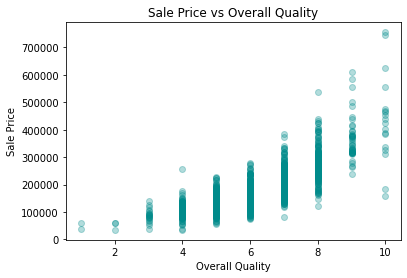

In [14]:
plt.scatter(data_cleaned["OverallQual"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.3)
plt.title('Sale Price vs Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.show()

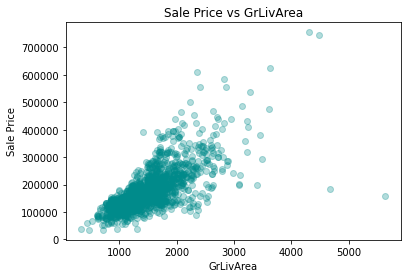

In [15]:
plt.scatter(data_cleaned["GrLivArea"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.3)
plt.title('Sale Price vs GrLivArea')
plt.xlabel('GrLivArea')
plt.ylabel('Sale Price')
plt.show()

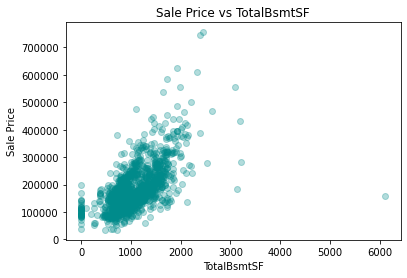

In [16]:
plt.scatter(data_cleaned["TotalBsmtSF"], data_cleaned["SalePrice"], c="darkcyan", alpha=0.3)
plt.title('Sale Price vs TotalBsmtSF')
plt.xlabel('TotalBsmtSF')
plt.ylabel('Sale Price')
plt.show()

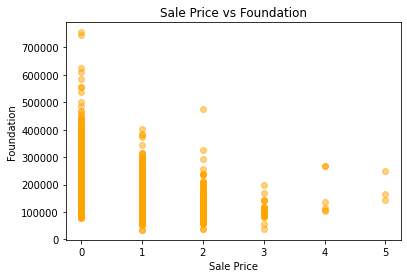

In [17]:
plt.scatter(data_cleaned["Foundation"], data_cleaned["SalePrice"], c="orange", alpha=0.5)
plt.title('Sale Price vs Foundation')
plt.xlabel('Sale Price')
plt.ylabel('Foundation')
plt.show()

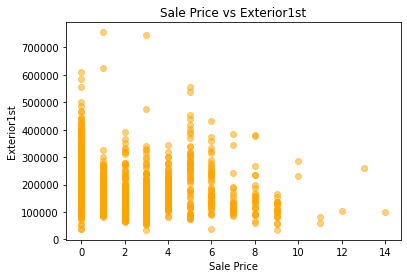

In [18]:
plt.scatter(data_cleaned["Exterior1st"], data_cleaned["SalePrice"], c="orange", alpha=0.5)
plt.title('Sale Price vs Exterior1st')
plt.xlabel('Sale Price')
plt.ylabel('Exterior1st')
plt.show()


To perform a PCA, the data should first be normalised. To do so, the data are scaled using their minimum and maximum values.
The dataset must be also divided in a train and test set.

In [19]:
print(data_cleaned.columns)
x = data_cleaned.iloc[:, 0:len(data_cleaned.columns)-2].to_numpy()
y = data_cleaned['SalePrice'].to_numpy()


# Train test split
train_test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=train_test_ratio, random_state=42)

print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [20]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Then the PCA is done. The explained variance ratio provides the amount of variance explained by each dimensions of the problem. These dimensions do not have clear meanings in our problem. 80% of the sale price could be explained by only 22 dimensions instead of 77 given at the begining.

In [21]:
pca = PCA()
pca.fit(X_train)
variance = np.cumsum(pca.explained_variance_ratio_)

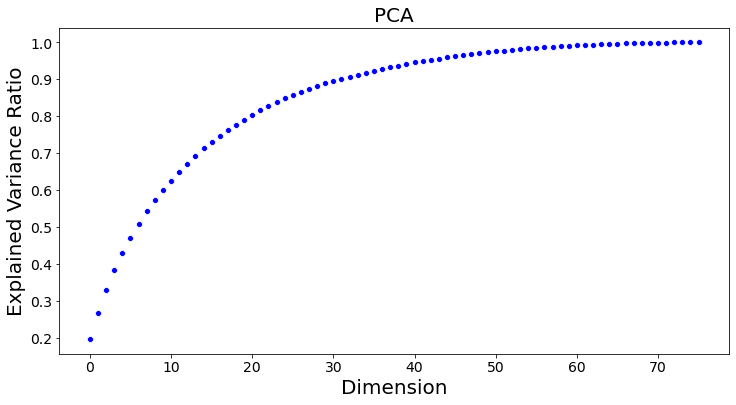

[0.19795411 0.26794419 0.33039492 0.38509386 0.43012084 0.47239073
 0.50991878 0.54418189 0.57419759 0.60112418 0.62606637 0.64995099
 0.67252077 0.6941613  0.71376339 0.73046002 0.7468343  0.76207118
 0.77661306 0.7908638  0.80456092 0.81711228 0.82880263 0.83928193]


In [22]:
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=variance,color='b')
ax.set_xlabel('Dimension', fontsize = 20)
ax.set_ylabel('Explained Variance Ratio', fontsize = 20)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.title("PCA", fontsize = 20)
plt.show()
print(variance[0:24])

In [23]:
pca = PCA(n_components=70)
pca.fit(X_train)
train_input = pca.transform(X_train)
test_input = pca.transform(X_test)
print(y_train)

[145000 178000  85000 ... 115000 189950 174000]


In [24]:
# Train folding (cross-val)
n = 6

cv = ShuffleSplit(n_splits=n, test_size=0.3, random_state=0)

print(cv)

ShuffleSplit(n_splits=6, random_state=0, test_size=0.3, train_size=None)


In [25]:
# Random prediction function
def random_prediction(x: np.ndarray, reg, n=5):
    size = x.shape[0]-1
    for _ in range(n):
        number = random.randint(0, size)
        y = y_test[number]
        y_hat = int(reg.predict(test_input[number].reshape(1, -1))[0])
        print(y_hat)
        print("Real price: ", y, " Predicted one: ", y_hat, " Error: ", int((y-y_hat)/y_hat*100), "%")

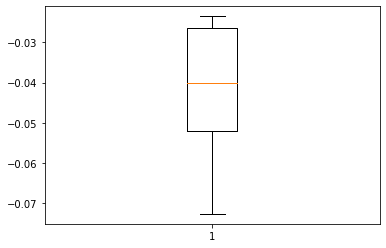

In [26]:
# SVM

parameters = [1]
mse_report = np.zeros((len(parameters), n))

for i, par in enumerate(parameters):
        reg = svm.SVR()
        mse_report[i, :] = cross_val_score(reg, train_input, y_train, cv=cv)
        
plt.boxplot(mse_report.T)
mu_perf = np.mean(mse_report, axis=1)
std_perf = np.std(mse_report, axis=1)
max_perf = np.max(mse_report, axis=1)
min_perf = np.min(mse_report, axis=1)

In [27]:

king_parameter = 1

reg.fit(train_input, y_train)
y_pred = reg.predict(test_input)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

MSE:  7855549195.698835
r2 score:  -0.024147993645714294


In [28]:
random_prediction(x=test_input, reg=reg)

164985
Real price:  207000  Predicted one:  164985  Error:  25 %
165038
Real price:  197000  Predicted one:  165038  Error:  19 %
165043
Real price:  185000  Predicted one:  165043  Error:  12 %
165035
Real price:  175900  Predicted one:  165035  Error:  6 %
164907
Real price:  79500  Predicted one:  164907  Error:  -51 %


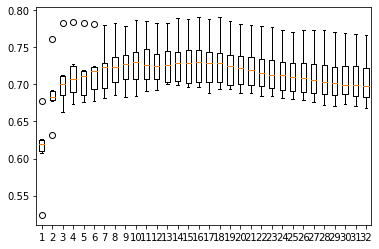

In [29]:
# KNN

parameters = [i for i in range(1, 33)]
mse_report = np.zeros((len(parameters), n))
test_report = np.zeros((len(parameters), 2))

for i, par in enumerate(parameters):
        reg = KNeighborsRegressor(n_neighbors=par, n_jobs=-1)
        mse_report[i, :] = cross_val_score(reg, train_input, y_train, cv=cv)
        reg.fit(train_input, y_train)
        y_pred = reg.predict(train_input)
        test_report[i, 0] = mean_squared_error(y_train, y_pred)
        y_pred = reg.predict(test_input)
        test_report[i, 1] = mean_squared_error(y_test, y_pred)
        
        
        
plt.boxplot(mse_report.T)
mu_perf = np.mean(mse_report, axis=1)
std_perf = np.std(mse_report, axis=1)
max_perf = np.max(mse_report, axis=1)
min_perf = np.min(mse_report, axis=1)

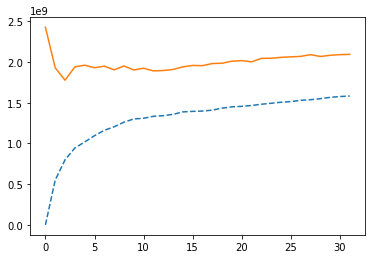

In [30]:
plt.plot(test_report[:, 0], "--")
plt.plot(test_report[:, 1])

In [31]:
king_parameter = 3
print(train_input.shape)
reg.fit(train_input, y_train)
y_pred = reg.predict(test_input)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

(1168, 70)
MSE:  2093207305.7984169
r2 score:  0.7271032223066245


In [32]:
random_prediction(x=test_input, reg=reg)

240608
Real price:  395000  Predicted one:  240608  Error:  64 %
132368
Real price:  132500  Predicted one:  132368  Error:  0 %
106178
Real price:  93500  Predicted one:  106178  Error:  -11 %
128470
Real price:  120000  Predicted one:  128470  Error:  -6 %
130735
Real price:  135000  Predicted one:  130735  Error:  3 %


{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 75, 50, 25), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 66, 33), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

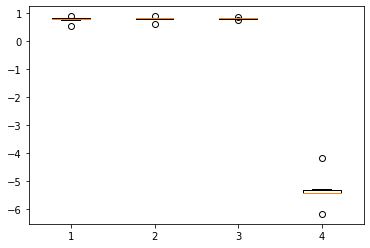

In [33]:
# FWW_NN

parameters = [(100, 75, 50, 25), (100, 66, 33), (100, 50), (100,)]
mse_report = np.zeros((len(parameters), n))

for i, par in enumerate(parameters):
        reg = MLPRegressor(hidden_layer_sizes=par, activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
        print(reg.get_params())
        mse_report[i, :] = cross_val_score(reg, train_input, y_train, cv=cv)
        
plt.boxplot(mse_report.T)
mu_perf = np.mean(mse_report, axis=1)
std_perf = np.std(mse_report, axis=1)
max_perf = np.max(mse_report, axis=1)
min_perf = np.min(mse_report, axis=1)

In [34]:
king_parameter = (100, 66, 33)

reg = MLPRegressor(hidden_layer_sizes=king_parameter, activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
reg.fit(train_input, y_train)
y_pred = reg.predict(test_input)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("r2 score: ", r2_score(y_test, y_pred))

MSE:  1083736910.024649
r2 score:  0.8587104536689478


/home/benoit/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [36]:
random_prediction(x=test_input, reg=reg, n=30)

377716
Real price:  337500  Predicted one:  377716  Error:  -10 %
252045
Real price:  262500  Predicted one:  252045  Error:  4 %
136759
Real price:  155000  Predicted one:  136759  Error:  13 %
188837
Real price:  175900  Predicted one:  188837  Error:  -6 %
119064
Real price:  105900  Predicted one:  119064  Error:  -11 %
147579
Real price:  153900  Predicted one:  147579  Error:  4 %
160246
Real price:  177500  Predicted one:  160246  Error:  10 %
167628
Real price:  175000  Predicted one:  167628  Error:  4 %
257962
Real price:  220000  Predicted one:  257962  Error:  -14 %
188837
Real price:  175900  Predicted one:  188837  Error:  -6 %
305779
Real price:  317000  Predicted one:  305779  Error:  3 %
88456
Real price:  108000  Predicted one:  88456  Error:  22 %
171687
Real price:  181000  Predicted one:  171687  Error:  5 %
130523
Real price:  92000  Predicted one:  130523  Error:  -29 %
135577
Real price:  128200  Predicted one:  135577  Error:  -5 %
140542
Real price:  160000  P